### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/ehdgus575/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [4]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [6]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [7]:
train_images = glob.glob('/data/segmentation/wound/trainset/images/*')
train_labels = glob.glob('/data/segmentation/wound/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/wound/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/wound/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 553 elements
My custom valing-dataset has 278 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

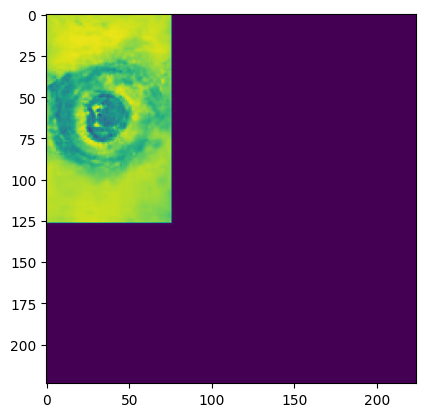

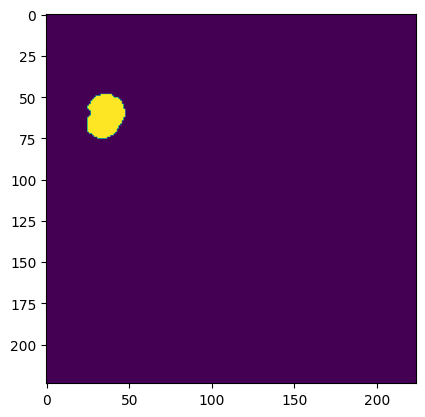

3픽셀의 평균값이라 색깔이 변경됨.


In [8]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [9]:
from models.FCBformer.FCBmodels import FCBFormer

model = FCBFormer(size=224)
model = model.to(DEVICE)

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [10]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCBFormer'
data_name = 'wound'

# 5. Training

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 70 of 70, Train Loss: 0.456360, IoU: 0.532671, Dice: 0.651144
 Epoch: 1 of 100, Iter.: 70 of 70, Valid Loss: 0.242155, IoU: 0.647028, Dice: 0.746560

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


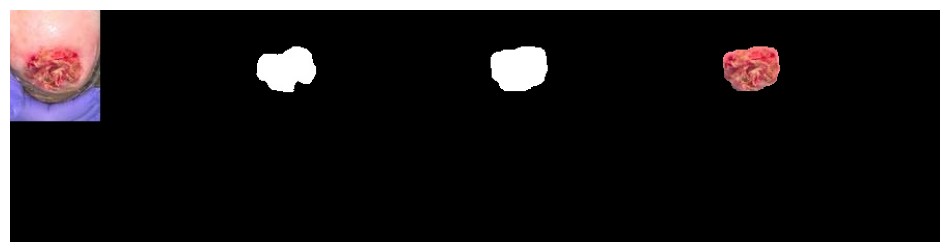

 Epoch: 2 of 100, Iter.: 70 of 70, Train Loss: 0.205134, IoU: 0.670455, Dice: 0.774769
 Epoch: 2 of 100, Iter.: 70 of 70, Valid Loss: 0.186863, IoU: 0.691950, Dice: 0.786868


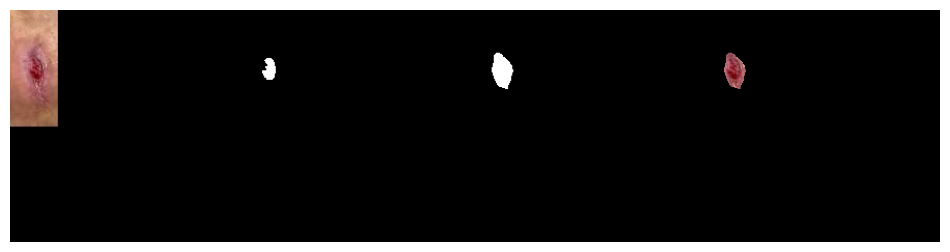

 Epoch: 3 of 100, Iter.: 70 of 70, Train Loss: 0.145780, IoU: 0.717215, Dice: 0.810504
 Epoch: 3 of 100, Iter.: 70 of 70, Valid Loss: 0.160053, IoU: 0.705851, Dice: 0.803434


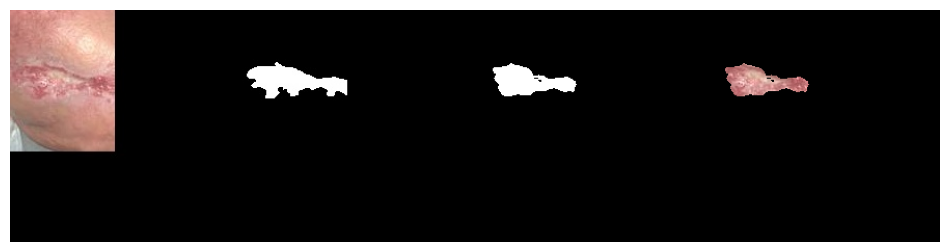

 Epoch: 4 of 100, Iter.: 70 of 70, Train Loss: 0.122239, IoU: 0.752986, Dice: 0.851937
 Epoch: 4 of 100, Iter.: 70 of 70, Valid Loss: 0.139681, IoU: 0.726986, Dice: 0.815319


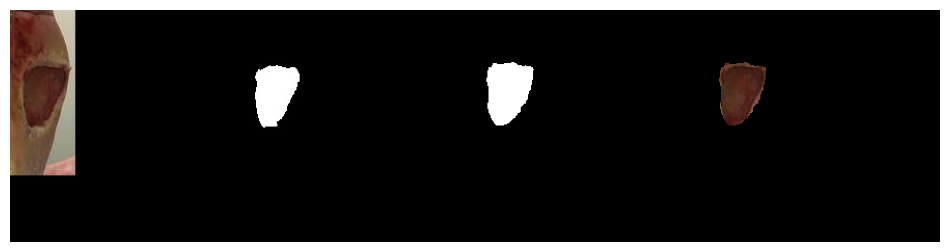

 Epoch: 5 of 100, Iter.: 70 of 70, Train Loss: 0.112440, IoU: 0.757107, Dice: 0.856773
 Epoch: 5 of 100, Iter.: 70 of 70, Valid Loss: 0.134008, IoU: 0.750026, Dice: 0.842360


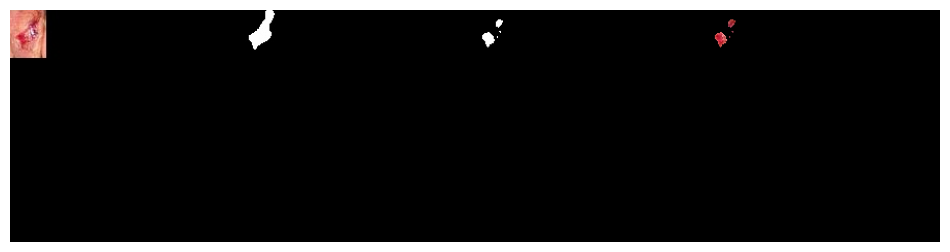

 Epoch: 6 of 100, Iter.: 70 of 70, Train Loss: 0.080939, IoU: 0.813450, Dice: 0.910447
 Epoch: 6 of 100, Iter.: 70 of 70, Valid Loss: 0.131757, IoU: 0.745598, Dice: 0.829848


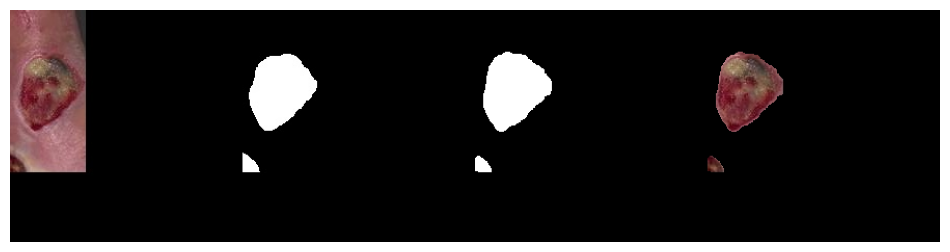

 Epoch: 7 of 100, Iter.: 70 of 70, Train Loss: 0.073192, IoU: 0.835857, Dice: 0.932535
 Epoch: 7 of 100, Iter.: 70 of 70, Valid Loss: 0.134705, IoU: 0.737488, Dice: 0.832881


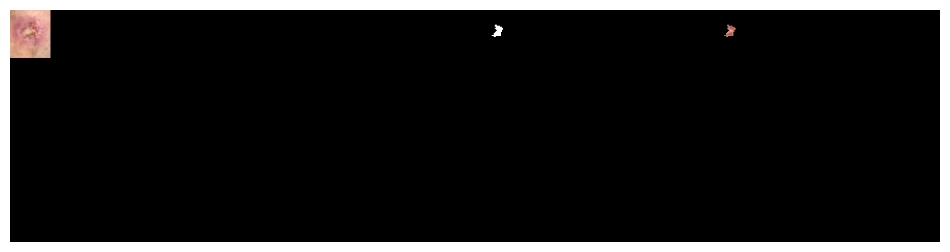

 Epoch: 8 of 100, Iter.: 70 of 70, Train Loss: 0.064707, IoU: 0.848112, Dice: 0.945875
 Epoch: 8 of 100, Iter.: 70 of 70, Valid Loss: 0.132285, IoU: 0.751799, Dice: 0.839585


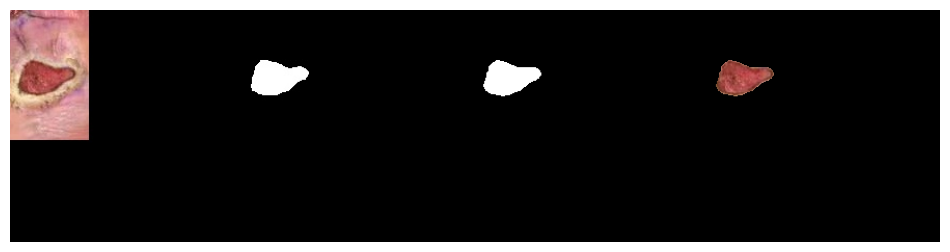

 Epoch: 9 of 100, Iter.: 70 of 70, Train Loss: 0.060376, IoU: 0.868773, Dice: 0.971229
 Epoch: 9 of 100, Iter.: 70 of 70, Valid Loss: 0.149158, IoU: 0.713385, Dice: 0.819655


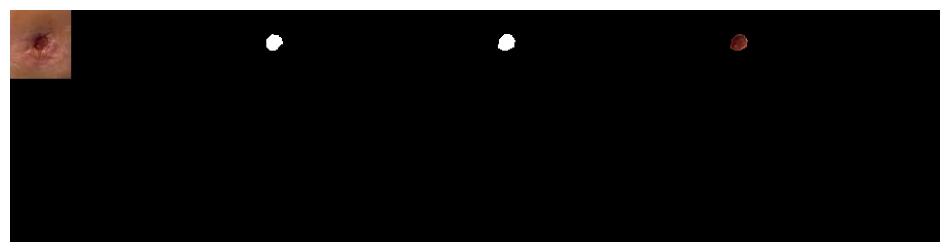

 Epoch: 10 of 100, Iter.: 70 of 70, Train Loss: 0.055914, IoU: 0.865893, Dice: 0.961473
 Epoch: 10 of 100, Iter.: 70 of 70, Valid Loss: 0.129917, IoU: 0.748141, Dice: 0.821629


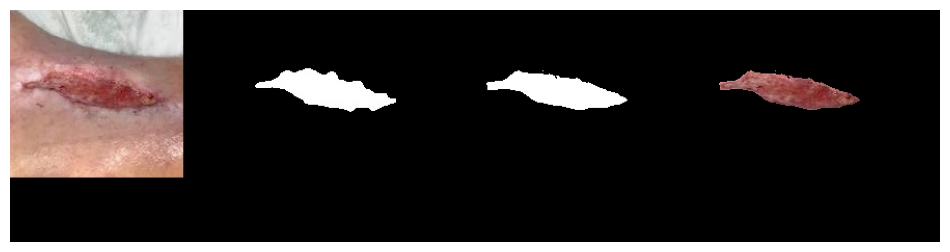

 Epoch: 11 of 100, Iter.: 70 of 70, Train Loss: 0.055409, IoU: 0.868188, Dice: 0.964858
 Epoch: 11 of 100, Iter.: 70 of 70, Valid Loss: 0.136371, IoU: 0.749790, Dice: 0.832942


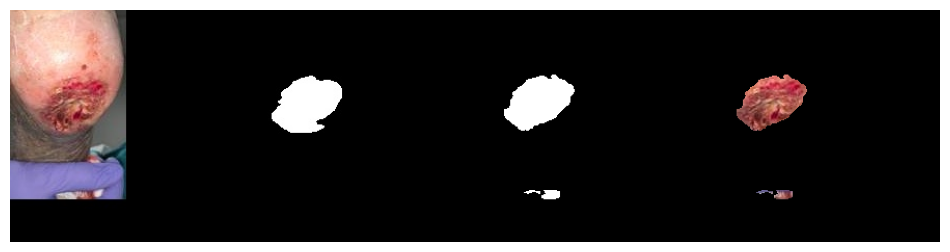

 Epoch: 12 of 100, Iter.: 70 of 70, Train Loss: 0.057817, IoU: 0.857957, Dice: 0.950698
 Epoch: 12 of 100, Iter.: 70 of 70, Valid Loss: 0.141692, IoU: 0.742126, Dice: 0.842452


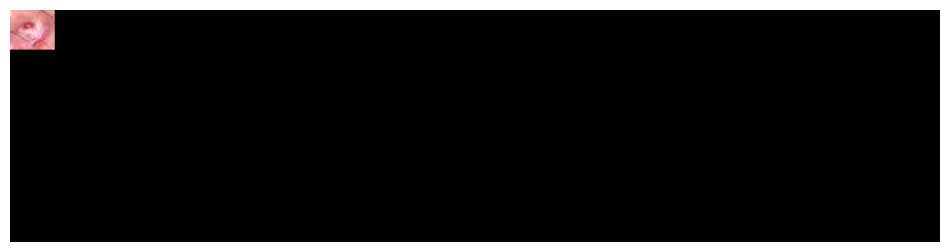

 Epoch: 13 of 100, Iter.: 70 of 70, Train Loss: 0.052784, IoU: 0.873257, Dice: 0.969854
 Epoch: 13 of 100, Iter.: 70 of 70, Valid Loss: 0.141181, IoU: 0.738969, Dice: 0.816761


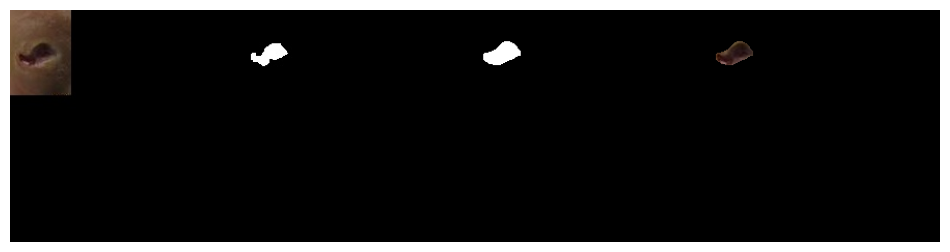

 Epoch: 14 of 100, Iter.: 70 of 70, Train Loss: 0.046564, IoU: 0.888046, Dice: 0.984588
 Epoch: 14 of 100, Iter.: 70 of 70, Valid Loss: 0.138620, IoU: 0.756190, Dice: 0.849066


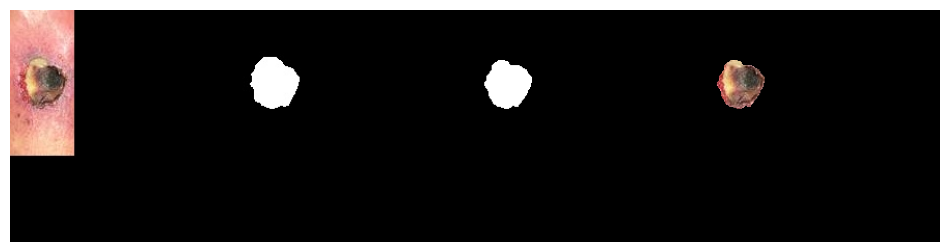

 Epoch: 15 of 100, Iter.: 70 of 70, Train Loss: 0.042672, IoU: 0.904490, Dice: 0.999824
 Epoch: 15 of 100, Iter.: 70 of 70, Valid Loss: 0.148060, IoU: 0.739620, Dice: 0.836010


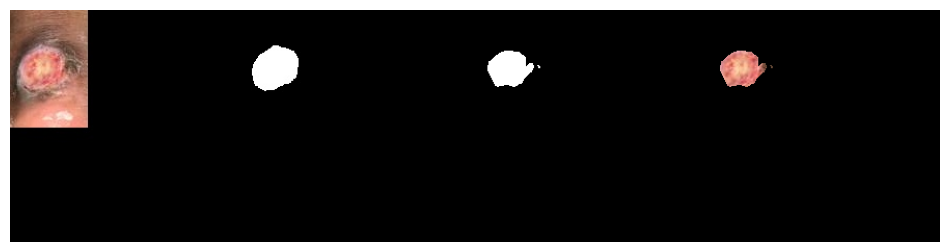

 Epoch: 16 of 100, Iter.: 70 of 70, Train Loss: 0.038760, IoU: 0.914281, Dice: 1.013344
 Epoch: 16 of 100, Iter.: 70 of 70, Valid Loss: 0.144125, IoU: 0.751246, Dice: 0.839226


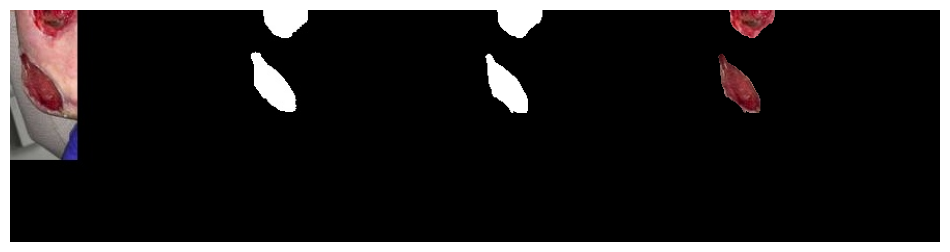

 Epoch: 17 of 100, Iter.: 70 of 70, Train Loss: 0.039841, IoU: 0.922232, Dice: 1.030999
 Epoch: 17 of 100, Iter.: 70 of 70, Valid Loss: 0.178290, IoU: 0.690216, Dice: 0.800382


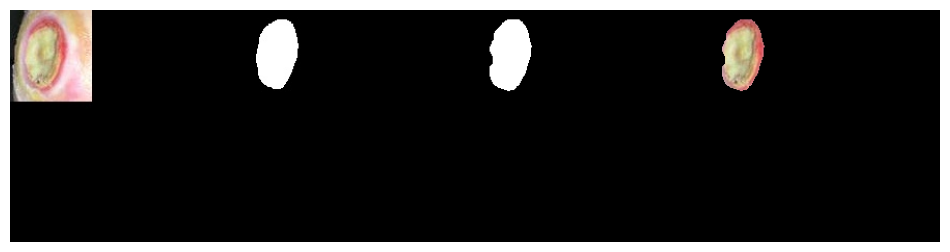

 Epoch: 18 of 100, Iter.: 70 of 70, Train Loss: 0.125285, IoU: 0.747195, Dice: 0.845882
 Epoch: 18 of 100, Iter.: 70 of 70, Valid Loss: 0.164069, IoU: 0.681431, Dice: 0.782683


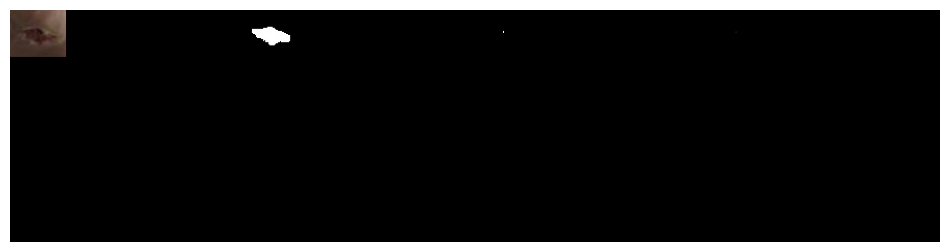

 Epoch: 19 of 100, Iter.: 70 of 70, Train Loss: 0.067824, IoU: 0.835218, Dice: 0.927912
 Epoch: 19 of 100, Iter.: 70 of 70, Valid Loss: 0.138108, IoU: 0.739734, Dice: 0.824706


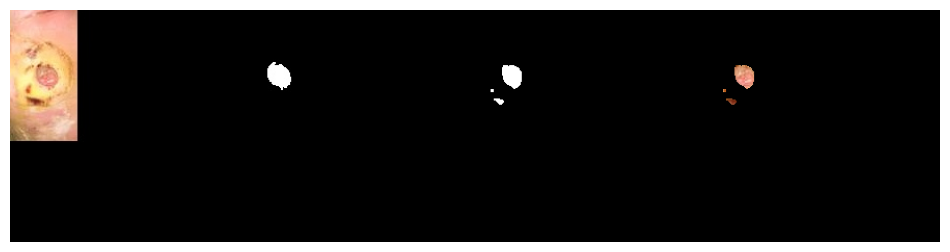

 Epoch: 20 of 100, Iter.: 70 of 70, Train Loss: 0.049560, IoU: 0.889617, Dice: 0.993911
 Epoch: 20 of 100, Iter.: 70 of 70, Valid Loss: 0.138622, IoU: 0.749137, Dice: 0.838268


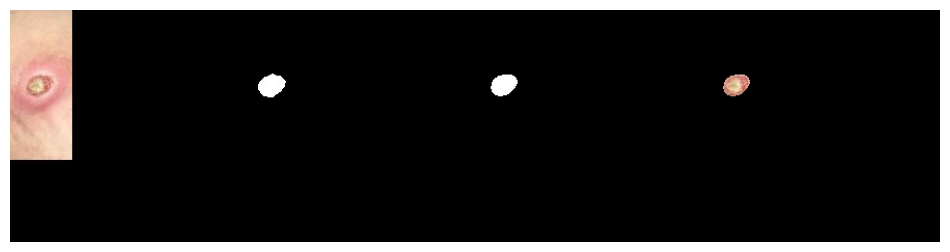

 Epoch: 21 of 100, Iter.: 70 of 70, Train Loss: 0.040794, IoU: 0.905352, Dice: 1.003916
 Epoch: 21 of 100, Iter.: 70 of 70, Valid Loss: 0.142655, IoU: 0.740910, Dice: 0.824565


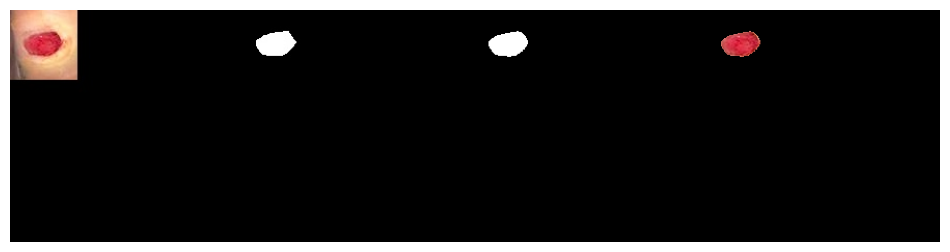

 Epoch: 22 of 100, Iter.: 70 of 70, Train Loss: 0.038609, IoU: 0.910615, Dice: 1.004861
 Epoch: 22 of 100, Iter.: 70 of 70, Valid Loss: 0.142556, IoU: 0.752047, Dice: 0.833883


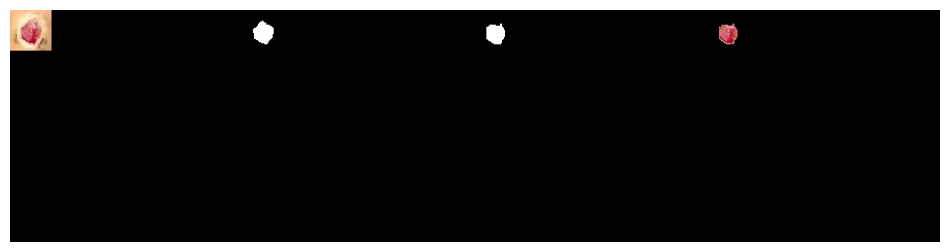

 Epoch: 23 of 100, Iter.: 70 of 70, Train Loss: 0.035057, IoU: 0.921538, Dice: 1.018739
 Epoch: 23 of 100, Iter.: 70 of 70, Valid Loss: 0.147433, IoU: 0.749430, Dice: 0.832426


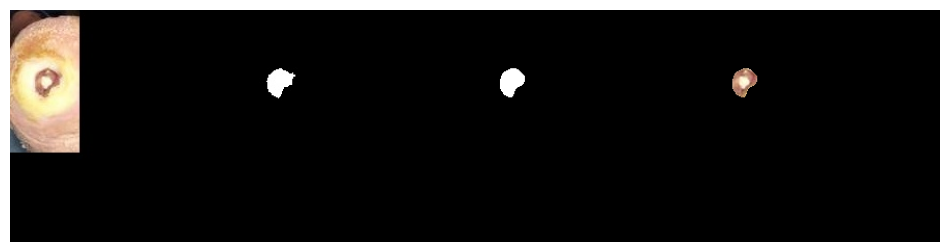

 Epoch: 24 of 100, Iter.: 70 of 70, Train Loss: 0.032864, IoU: 0.925435, Dice: 1.018505
 Epoch: 24 of 100, Iter.: 70 of 70, Valid Loss: 0.149624, IoU: 0.754678, Dice: 0.836663


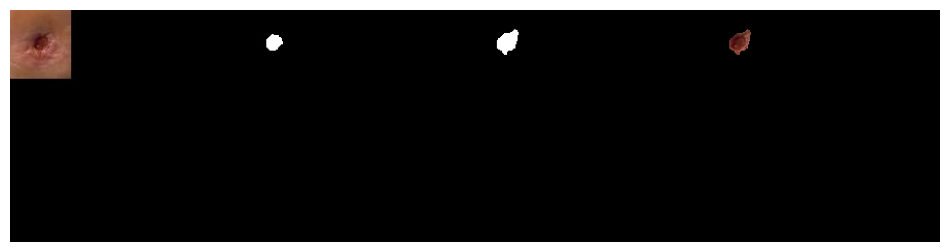

 Epoch: 25 of 100, Iter.: 70 of 70, Train Loss: 0.034203, IoU: 0.921058, Dice: 1.013538
 Epoch: 25 of 100, Iter.: 70 of 70, Valid Loss: 0.151159, IoU: 0.746561, Dice: 0.832739


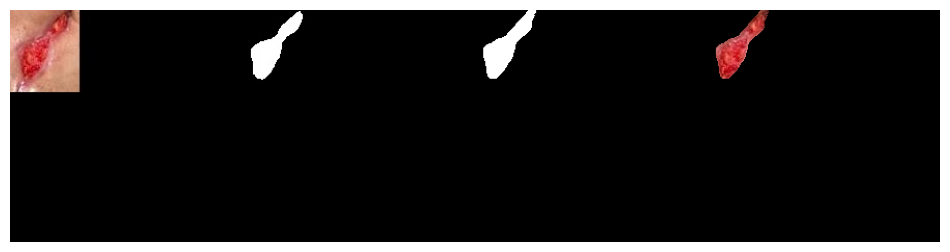

 Epoch: 26 of 100, Iter.: 70 of 70, Train Loss: 0.033708, IoU: 0.919983, Dice: 1.010365
 Epoch: 26 of 100, Iter.: 70 of 70, Valid Loss: 0.153138, IoU: 0.748254, Dice: 0.831464


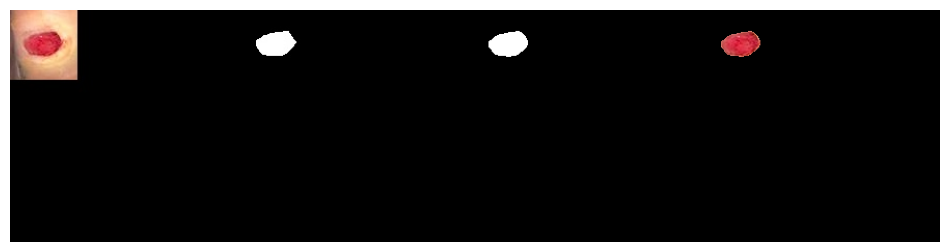

 Epoch: 27 of 100, Iter.: 70 of 70, Train Loss: 0.034588, IoU: 0.924207, Dice: 1.015462
 Epoch: 27 of 100, Iter.: 70 of 70, Valid Loss: 0.151387, IoU: 0.754133, Dice: 0.835300


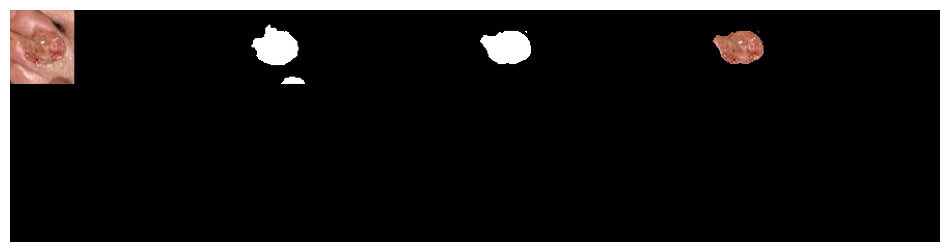

 Epoch: 28 of 100, Iter.: 70 of 70, Train Loss: 0.030011, IoU: 0.931208, Dice: 1.021991
 Epoch: 28 of 100, Iter.: 70 of 70, Valid Loss: 0.156955, IoU: 0.750936, Dice: 0.832836


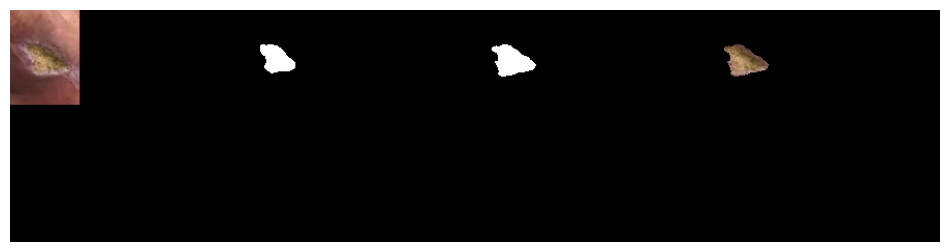

 Epoch: 29 of 100, Iter.: 70 of 70, Train Loss: 0.028447, IoU: 0.931843, Dice: 1.019373
 Epoch: 29 of 100, Iter.: 70 of 70, Valid Loss: 0.158047, IoU: 0.749940, Dice: 0.826406


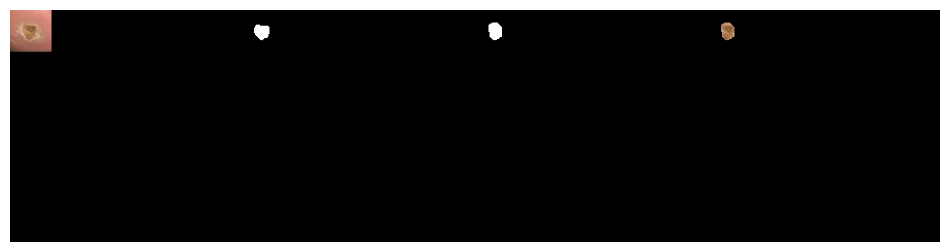

 Epoch: 30 of 100, Iter.: 70 of 70, Train Loss: 0.027691, IoU: 0.938769, Dice: 1.028614
 Epoch: 30 of 100, Iter.: 70 of 70, Valid Loss: 0.161066, IoU: 0.752941, Dice: 0.839311


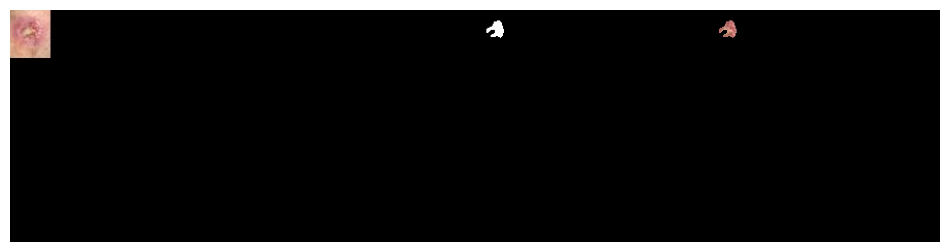

 Epoch: 31 of 100, Iter.: 70 of 70, Train Loss: 0.026949, IoU: 0.939386, Dice: 1.026659
 Epoch: 31 of 100, Iter.: 70 of 70, Valid Loss: 0.167053, IoU: 0.744079, Dice: 0.827631


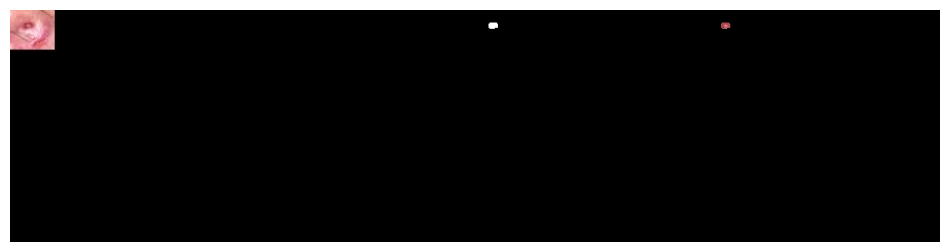

 Epoch: 32 of 100, Iter.: 70 of 70, Train Loss: 0.027378, IoU: 0.929384, Dice: 1.012810
 Epoch: 32 of 100, Iter.: 70 of 70, Valid Loss: 0.166234, IoU: 0.752513, Dice: 0.834939


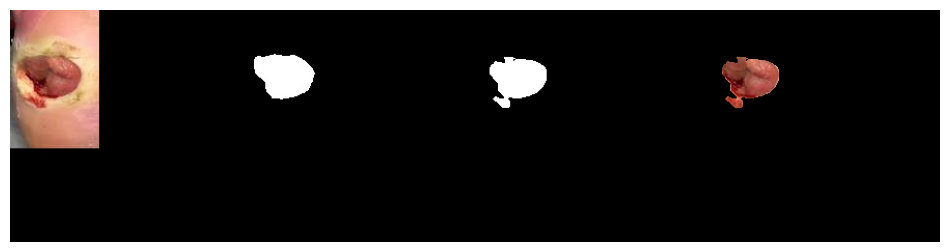

 Epoch: 33 of 100, Iter.: 70 of 70, Train Loss: 0.026572, IoU: 0.940909, Dice: 1.029998
 Epoch: 33 of 100, Iter.: 70 of 70, Valid Loss: 0.164642, IoU: 0.745149, Dice: 0.822235


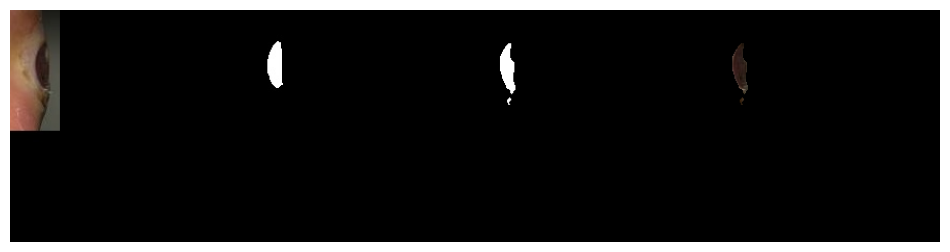

 Epoch: 34 of 100, Iter.: 70 of 70, Train Loss: 0.027148, IoU: 0.942520, Dice: 1.031175
 Epoch: 34 of 100, Iter.: 70 of 70, Valid Loss: 0.169574, IoU: 0.744541, Dice: 0.822576


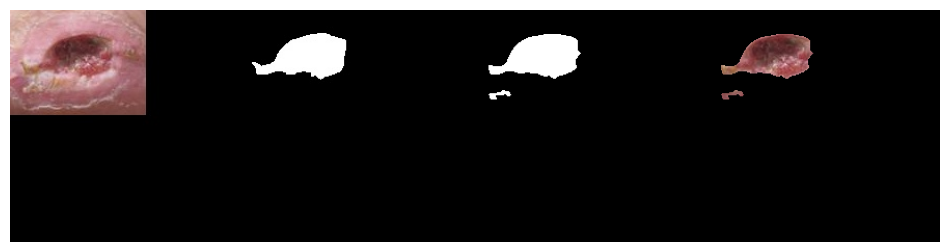

 Epoch: 35 of 100, Iter.: 70 of 70, Train Loss: 0.025795, IoU: 0.933691, Dice: 1.015068
 Epoch: 35 of 100, Iter.: 70 of 70, Valid Loss: 0.170680, IoU: 0.751540, Dice: 0.834223


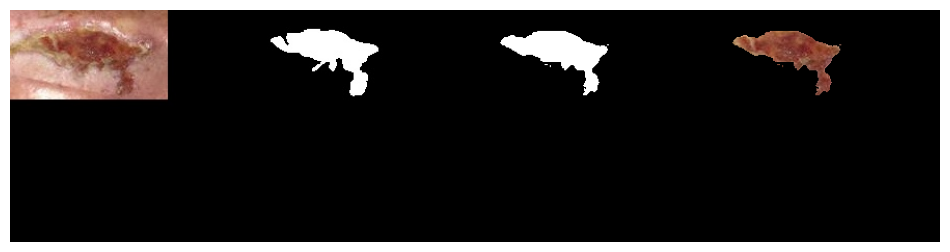


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 1h 2min 20s, sys: 28min 25s, total: 1h 30min 46s
Wall time: 1h 28min 52s


In [12]:
%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/ehdgus575/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:14, Best_IOU:0.7562, Best_DiceScore:0.8491


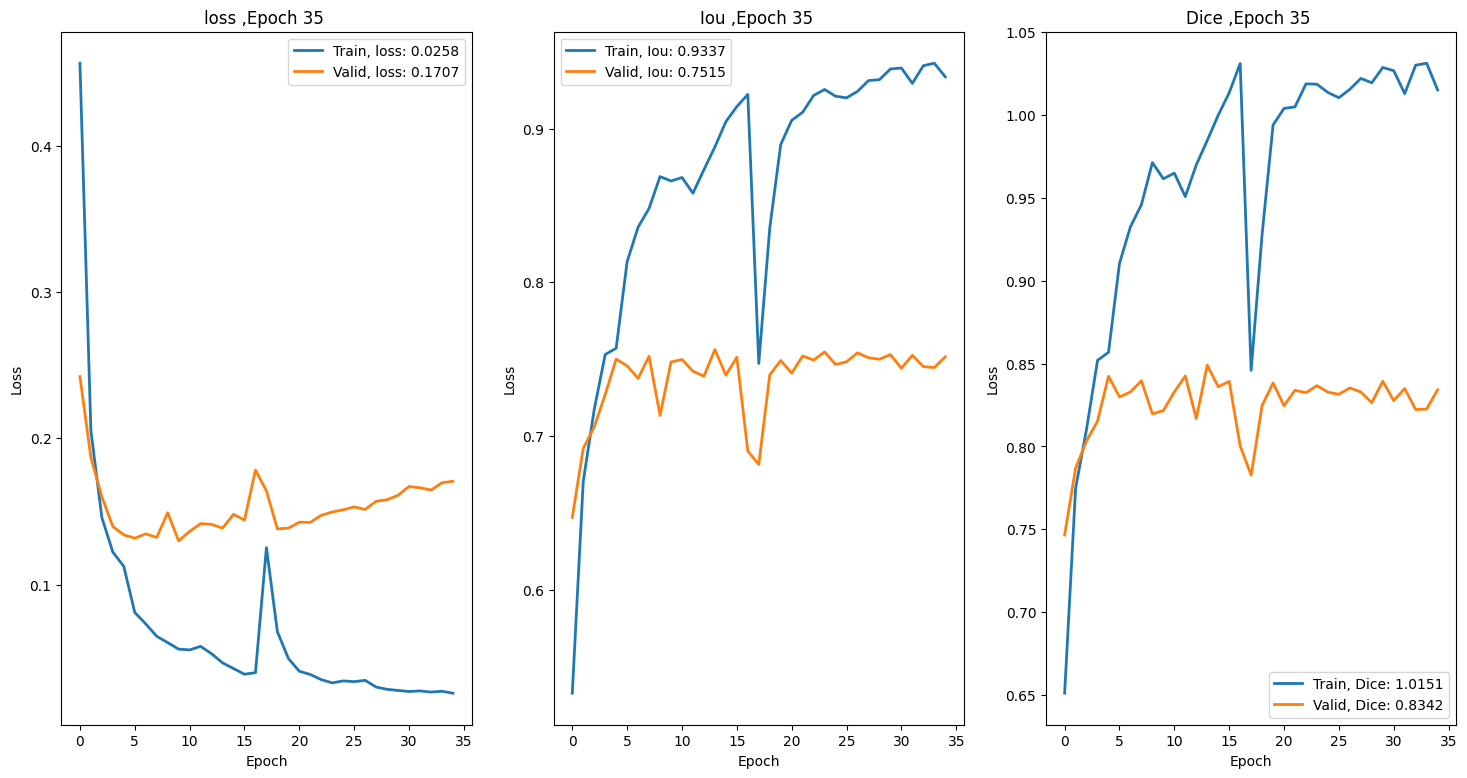

In [13]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')
#print(f'End_time: {end_time}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()